In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import src.modules.utils as utils
import src.modules.face_utils as ft
import src.modules.data_manipulation as dm
import src.modules.face_api as api
import src.modules.stat_utils as st
from src.modules.image_preprocessor import ImagePreprocessor
from sklearn.metrics import PrecisionRecallDisplay, auc

2024-08-06 02:39:54.671274: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-06 02:39:54.709045: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-06 02:39:54.710359: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 02:39:55.491833: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Preprocessing Visualizations

In [19]:
name = 'Aishwarya Rai'
num = 1
image_path = os.path.join('./data/raw/train', f'{"_".join(name.split())}_{num:04d}.jpg')
processor = ImagePreprocessor(image_path)

In [20]:
base_image = processor.get_image()[:, :, ::-1]
processor.preprocess_image(steps = 'align', alignment_backend = 'dlib')
dlib_aligned = processor.get_aligned_image()[:, :, ::-1]
processor.preprocess_image(steps = 'align', alignment_backend = 'retinaface')
rf_aligned = processor.get_aligned_image()[:, :, ::-1]
processor.preprocess_image(steps = 'align', alignment_backend = 'mediapipe')
mp_aligned = processor.get_aligned_image()[:, :, ::-1]

I0000 00:00:1722882179.629916   42984 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1722882179.632334   43247 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)


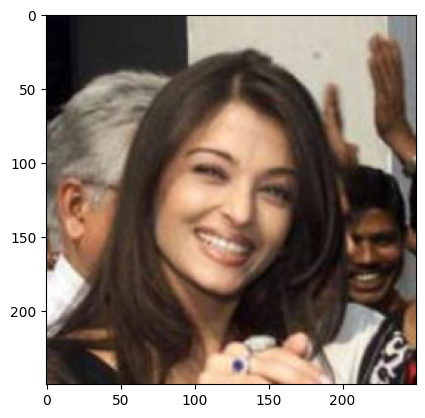

In [21]:
plt.imshow(base_image);

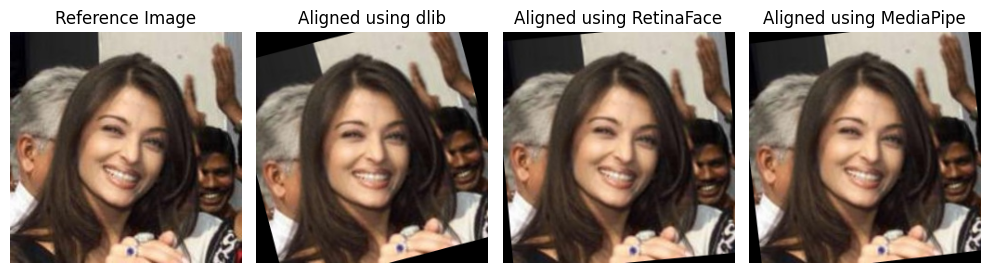

In [85]:
fig, ax = plt.subplots(1, 4, figsize = (10, 10))

ax[0].imshow(base_image);
ax[1].imshow(dlib_aligned);
ax[2].imshow(rf_aligned);
ax[3].imshow(mp_aligned);

ax[0].set_title('Reference Image');
ax[1].set_title('Aligned using dlib');
ax[2].set_title('Aligned using RetinaFace');
ax[3].set_title('Aligned using MediaPipe');

for axis in ax:
    axis.set_xticks([]);
    axis.set_yticks([]);
    axis.axis('off');


plt.tight_layout();

plt.savefig('./Visualizations/Alignment_Comparison.png', format = 'png', bbox_inches = 'tight')

In [86]:
processor.preprocess_image(steps = ['align', 'crop'], alignment_backend = 'dlib', crop_backend = 'dlib')
dlib_region = processor.get_facial_region()
processor.preprocess_image(steps = ['align', 'crop'], alignment_backend = 'dlib', crop_backend = 'retinaface')
rf_region = processor.get_facial_region()
processor.preprocess_image(steps = ['align', 'crop'], alignment_backend = 'dlib', crop_backend = 'mediapipe')
mp_region = processor.get_facial_region()
mp_details = processor.get_backend_details('mediapipe')

I0000 00:00:1722884686.913207   42984 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1722884686.916338   44341 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)


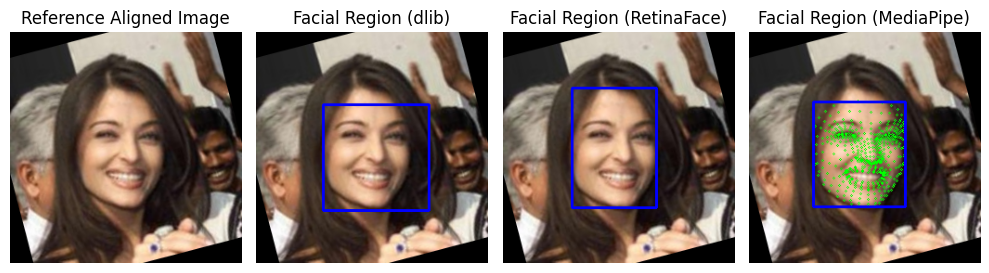

In [87]:
fig, ax = plt.subplots(1, 4, figsize = (10, 10))

dlib_bounds = dlib_aligned.copy()
rf_bounds = dlib_aligned.copy()
mp_bounds = dlib_aligned.copy()

cv2.rectangle(dlib_bounds, (dlib_region[0], dlib_region[2]), (dlib_region[1], dlib_region[3]), (0, 0, 255), 2)
cv2.rectangle(rf_bounds, (rf_region[0], rf_region[2]), (rf_region[1], rf_region[3]), (0, 0, 255), 2)
for landmark in mp_details.landmark:
    cv2.circle(mp_bounds, ft.normal_to_pixel(landmark.x, landmark.y, 250, 250), 1, (0, 255, 0), 1)

cv2.rectangle(mp_bounds, (mp_region[0], mp_region[2]), (mp_region[1], mp_region[3]), (0, 0, 255), 2)

ax[0].imshow(dlib_aligned);
ax[1].imshow(dlib_bounds);
ax[2].imshow(rf_bounds);
ax[3].imshow(mp_bounds);

ax[0].set_title('Reference Aligned Image');
ax[1].set_title('Facial Region (dlib)');
ax[2].set_title('Facial Region (RetinaFace)');
ax[3].set_title('Facial Region (MediaPipe)');

for axis in ax:
    axis.set_xticks([]);
    axis.set_yticks([]);
    axis.axis('off');

plt.tight_layout();
    
plt.savefig('./Visualizations/Facial_Region_Comparison.png', format = 'png', bbox_inches = 'tight')

In [88]:
processor.preprocess_image(steps = 'full', pad = True)
padded_image = processor.get_resized_image()[:, :, ::-1]
processor.preprocess_image(steps = 'full', pad = False)
stretched_image = processor.get_resized_image()[:, :, ::-1]
processor.preprocess_ghosh()
ghosh_image = processor.get_resized_image()[:, :, ::-1]

I0000 00:00:1722884687.909120   42984 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1722884687.912744   44346 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
I0000 00:00:1722884688.290263   42984 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1722884688.292035   44351 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)


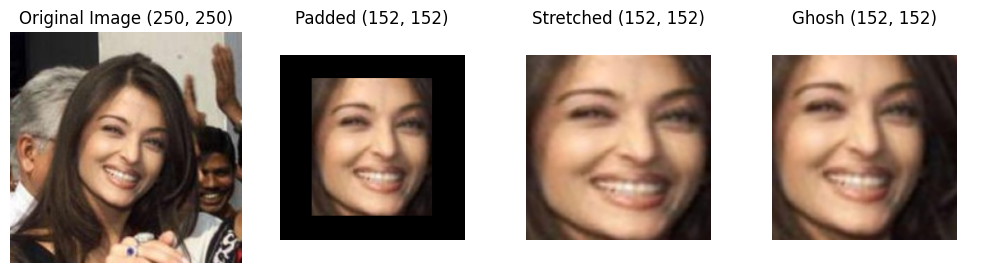

In [92]:
fig, ax = plt.subplots(1, 4, figsize = (10, 10), sharex = True, sharey = True)

ax[1].imshow(padded_image, extent = [25, 225, 225, 25]);
ax[2].imshow(stretched_image, extent = [25, 225, 225, 25]);
ax[3].imshow(ghosh_image, extent = [25, 225, 225, 25]);
ax[0].imshow(base_image);

ax[0].set_title('Original Image (250, 250)');
ax[1].set_title('Padded (152, 152)');
ax[2].set_title('Stretched (152, 152)');
ax[3].set_title('Ghosh (152, 152)');

for axis in ax:
    axis.set_xticks([]);
    axis.set_yticks([]);
    axis.axis('off');

plt.tight_layout();
    
plt.savefig('./Visualizations/Preprocessing_Pipeline_Comparisons.png', format = 'png', bbox_inches = 'tight')

In [90]:
ghosh_extracted = processor.get_cropped_image()[:, :, ::-1]

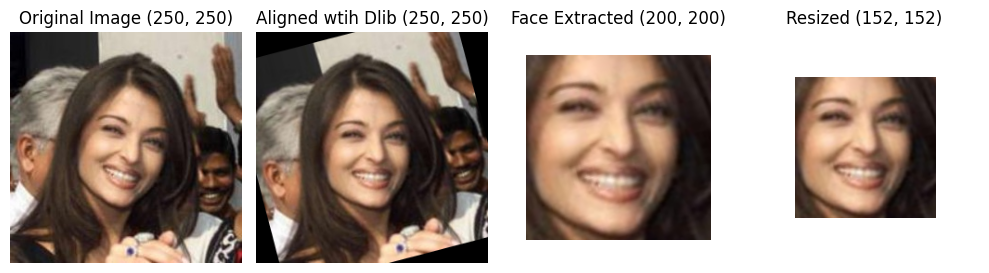

In [93]:
fig, ax = plt.subplots(1, 4, figsize = (10, 10), sharex = True, sharey = True)

ax[2].imshow(ghosh_extracted, extent = [25, 225, 225, 25]);
ax[3].imshow(ghosh_image, extent = [49, 201, 201, 49]);
ax[0].imshow(base_image);
ax[1].imshow(dlib_aligned);


ax[0].set_title('Original Image (250, 250)');
ax[1].set_title('Aligned wtih Dlib (250, 250)');
ax[2].set_title('Face Extracted (200, 200)');
ax[3].set_title('Resized (152, 152)');

for axis in ax:
    axis.set_xticks([]);
    axis.set_yticks([]);
    axis.axis('off');

plt.tight_layout();
    
plt.savefig('./Visualizations/Ghosh_Preprocessing_Pipeline.png', format = 'png', bbox_inches = 'tight')

# Distribution Visualizations

In [2]:
intra_l2_path = './data/vectorized/padded_152_intra_distances_l2.csv'
intra_l2_df = pd.read_csv(intra_l2_path)
inter_l2_df = dm.get_unbatched_frame('padded_152_inter_distances_', 'l2')
intra_l2_df['Type'] = 'Match'
inter_l2_df['Type'] = 'Mismatch'
l2_df = pd.concat([intra_l2_df, inter_l2_df])
intra_l2_df = 0
inter_l2_df = 0

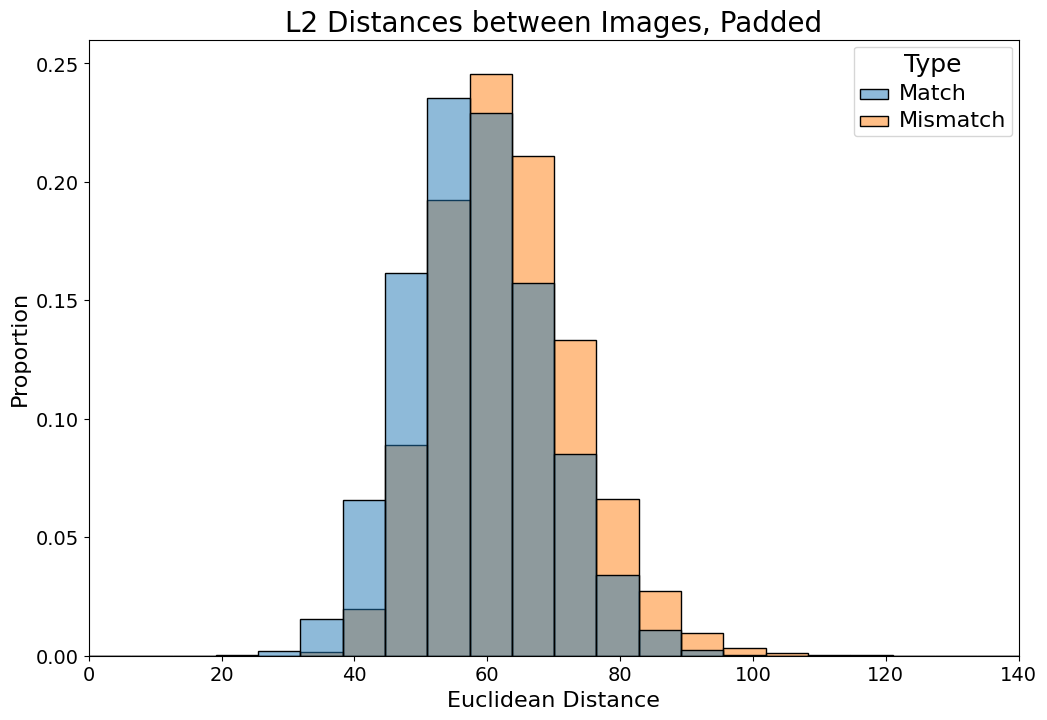

In [3]:
# Overlaid distributes of inter- and intra-label l2 distances
fig, ax = plt.subplots(1, figsize = (12, 8))

sns.histplot(data = l2_df, x = 'l2_distances', hue = 'Type',
             stat = 'proportion', common_norm = False, bins = 25, ax = ax);

ax.set_title('L2 Distances between Images, Padded', fontsize = 20);
ax.set_xlabel('Euclidean Distance', fontsize = 16);
ax.set_ylabel('Proportion', fontsize = 16);

ax.set_xlim([0, 140]);
ax.set_ylim([0, 0.26]);

plt.setp(ax.get_legend().get_texts(), fontsize = 16);
plt.setp(ax.get_legend().get_title(), fontsize = 18);

ax.tick_params(axis = 'both', labelsize = 14);
plt.savefig('./Visualizations/padded_l2_distances.png', format = 'png', bbox_inches = 'tight')

In [4]:
intra_l2_path = './data/vectorized/stretched_152_intra_distances_l2.csv'
intra_l2_df = pd.read_csv(intra_l2_path)
inter_l2_df = dm.get_unbatched_frame('stretched_152_inter_distances_', 'l2')
intra_l2_df['Type'] = 'Match'
inter_l2_df['Type'] = 'Mismatch'
l2_df = pd.concat([intra_l2_df, inter_l2_df])
intra_l2_df = 0
inter_l2_df = 0

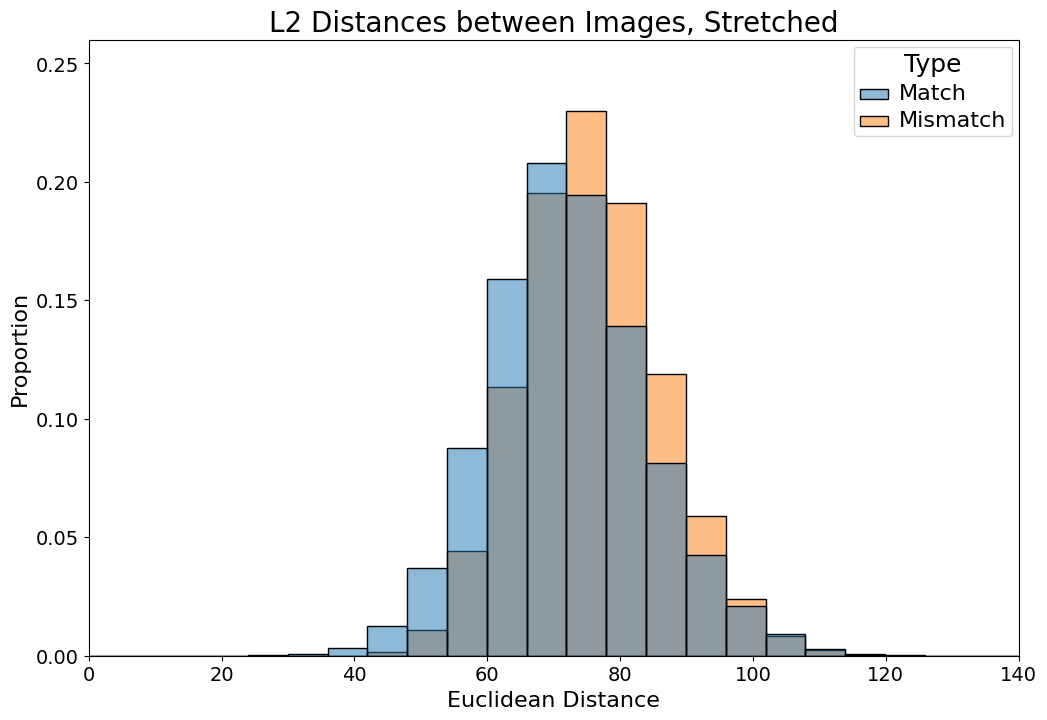

In [5]:
# Overlaid distributes of inter- and intra-label l2 distances
fig, ax = plt.subplots(1, figsize = (12, 8))

sns.histplot(data = l2_df, x = 'l2_distances', hue = 'Type',
             stat = 'proportion', common_norm = False, bins = 25, ax = ax);

ax.set_title('L2 Distances between Images, Stretched', fontsize = 20);
ax.set_xlabel('Euclidean Distance', fontsize = 16);
ax.set_ylabel('Proportion', fontsize = 16);

ax.set_xlim([0, 140]);
ax.set_ylim([0, 0.26]);

plt.setp(ax.get_legend().get_texts(), fontsize = 16);
plt.setp(ax.get_legend().get_title(), fontsize = 18);

ax.tick_params(axis = 'both', labelsize = 14);
plt.savefig('./Visualizations/stretched_l2_distances.png', format = 'png', bbox_inches = 'tight')

In [6]:
intra_l2_path = './data/vectorized/ghosh_152_intra_distances_l2.csv'
intra_l2_df = pd.read_csv(intra_l2_path)
inter_l2_df = dm.get_unbatched_frame('ghosh_152_inter_distances_', 'l2')
intra_l2_df['Type'] = 'Match'
inter_l2_df['Type'] = 'Mismatch'
l2_df = pd.concat([intra_l2_df, inter_l2_df])
intra_l2_df = 0
inter_l2_df = 0

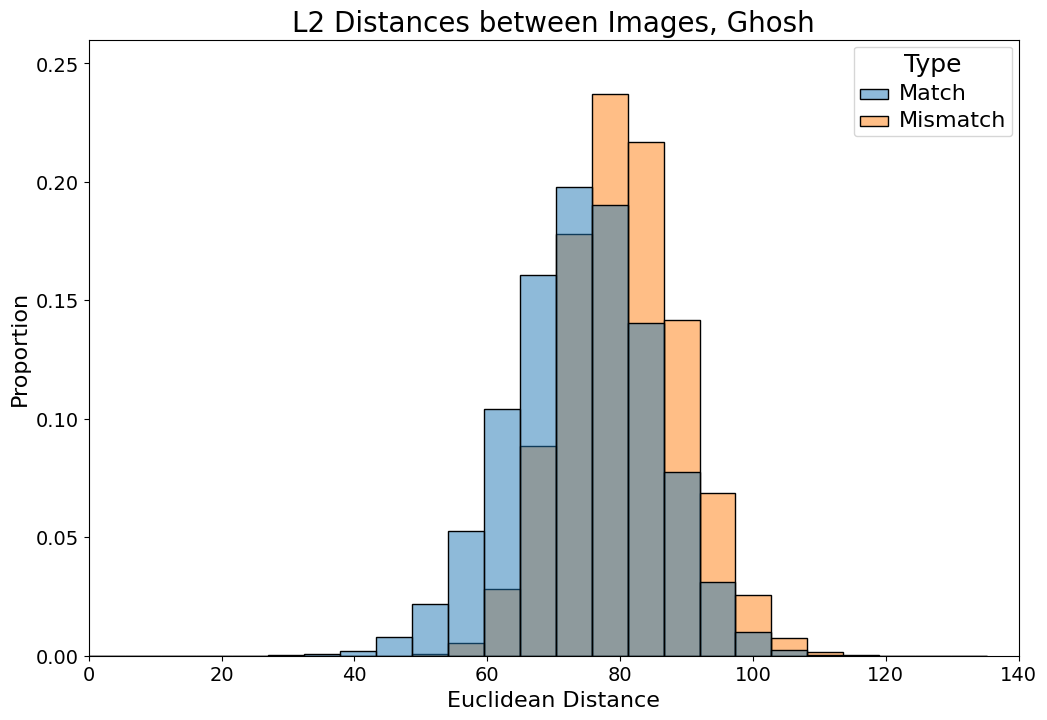

In [7]:
# Overlaid distributes of inter- and intra-label l2 distances
fig, ax = plt.subplots(1, figsize = (12, 8))

sns.histplot(data = l2_df, x = 'l2_distances', hue = 'Type',
             stat = 'proportion', common_norm = False, bins = 25, ax = ax);

ax.set_title('L2 Distances between Images, Ghosh', fontsize = 20);
ax.set_xlabel('Euclidean Distance', fontsize = 16);
ax.set_ylabel('Proportion', fontsize = 16);

ax.set_xlim([0, 140]);
ax.set_ylim([0, 0.26]);

plt.setp(ax.get_legend().get_texts(), fontsize = 16);
plt.setp(ax.get_legend().get_title(), fontsize = 18);

ax.tick_params(axis = 'both', labelsize = 14);
plt.savefig('./Visualizations/ghosh_l2_distances.png', format = 'png', bbox_inches = 'tight')

In [2]:
intra_cos_path = './data/vectorized/padded_152_intra_distances_cos.csv'
intra_cos_df = pd.read_csv(intra_cos_path)
inter_cos_df = dm.get_unbatched_frame('padded_152_inter_distances_', 'cos')
intra_cos_df['Type'] = 'Match'
inter_cos_df['Type'] = 'Mismatch'
cos_df = pd.concat([intra_cos_df, inter_cos_df])
intra_cos_df = 0
inter_cos_df = 0

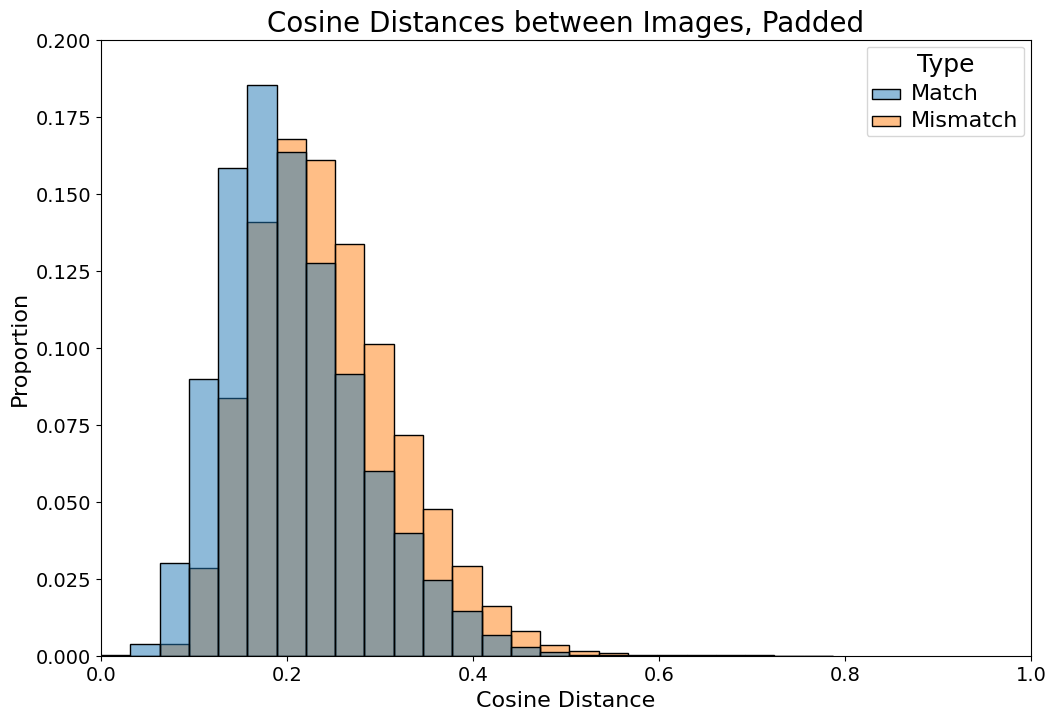

In [3]:
# Overlaid distributes of inter- and intra-label cos distances
fig, ax = plt.subplots(1, figsize = (12, 8))

sns.histplot(data = cos_df, x = 'cosine_distances', hue = 'Type',
             stat = 'proportion', common_norm = False, bins = 25, ax = ax);

ax.set_title('Cosine Distances between Images, Padded', fontsize = 20);
ax.set_xlabel('Cosine Distance', fontsize = 16);
ax.set_ylabel('Proportion', fontsize = 16);

ax.set_xlim([0, 1]);
ax.set_ylim([0, 0.2]);

plt.setp(ax.get_legend().get_texts(), fontsize = 16);
plt.setp(ax.get_legend().get_title(), fontsize = 18);

ax.tick_params(axis = 'both', labelsize = 14);
plt.savefig('./Visualizations/padded_cos_distances.png', format = 'png', bbox_inches = 'tight')

In [4]:
intra_cos_path = './data/vectorized/stretched_152_intra_distances_cos.csv'
intra_cos_df = pd.read_csv(intra_cos_path)
inter_cos_df = dm.get_unbatched_frame('stretched_152_inter_distances_', 'cos')
intra_cos_df['Type'] = 'Match'
inter_cos_df['Type'] = 'Mismatch'
cos_df = pd.concat([intra_cos_df, inter_cos_df])
intra_cos_df = 0
inter_cos_df = 0

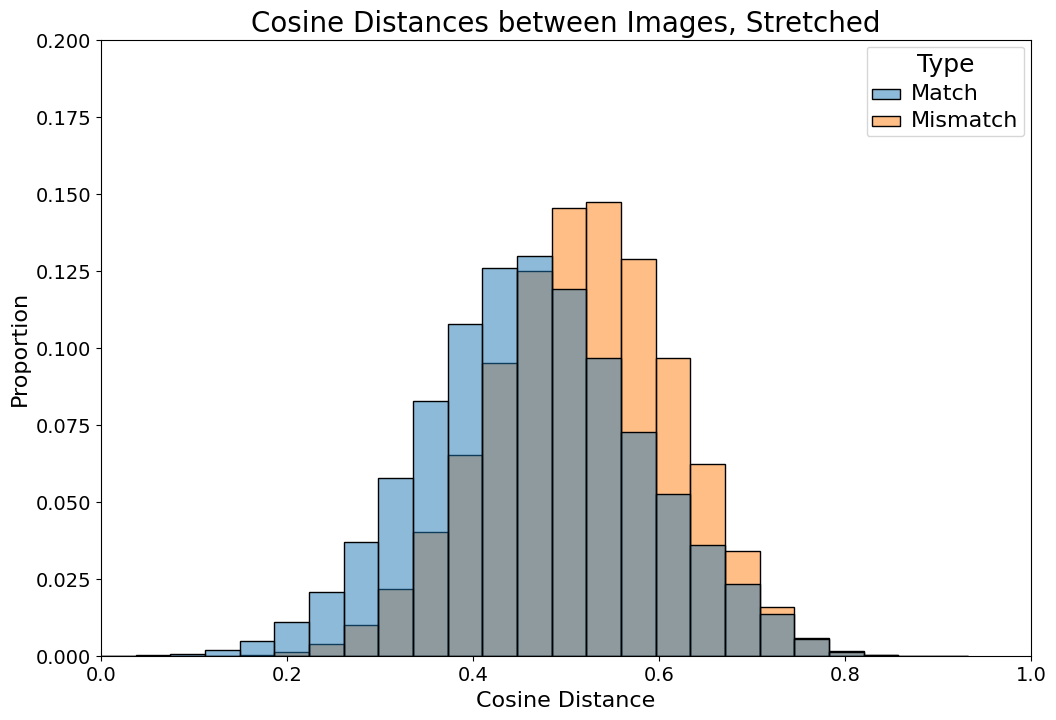

In [5]:
# Overlaid distributes of inter- and intra-label cos distances
fig, ax = plt.subplots(1, figsize = (12, 8))

sns.histplot(data = cos_df, x = 'cosine_distances', hue = 'Type',
             stat = 'proportion', common_norm = False, bins = 25, ax = ax);

ax.set_title('Cosine Distances between Images, Stretched', fontsize = 20);
ax.set_xlabel('Cosine Distance', fontsize = 16);
ax.set_ylabel('Proportion', fontsize = 16);

ax.set_xlim([0, 1]);
ax.set_ylim([0, 0.2]);

plt.setp(ax.get_legend().get_texts(), fontsize = 16);
plt.setp(ax.get_legend().get_title(), fontsize = 18);

ax.tick_params(axis = 'both', labelsize = 14);
plt.savefig('./Visualizations/stretched_cos_distances.png', format = 'png', bbox_inches = 'tight')

In [10]:
intra_cos_path = './data/vectorized/ghosh_152_intra_distances_cos.csv'
intra_cos_df = pd.read_csv(intra_cos_path)
inter_cos_df = dm.get_unbatched_frame('ghosh_152_inter_distances_', 'cos')
intra_cos_df['Type'] = 'Match'
inter_cos_df['Type'] = 'Mismatch'
cos_df = pd.concat([intra_cos_df, inter_cos_df])
intra_cos_df = 0
inter_cos_df = 0

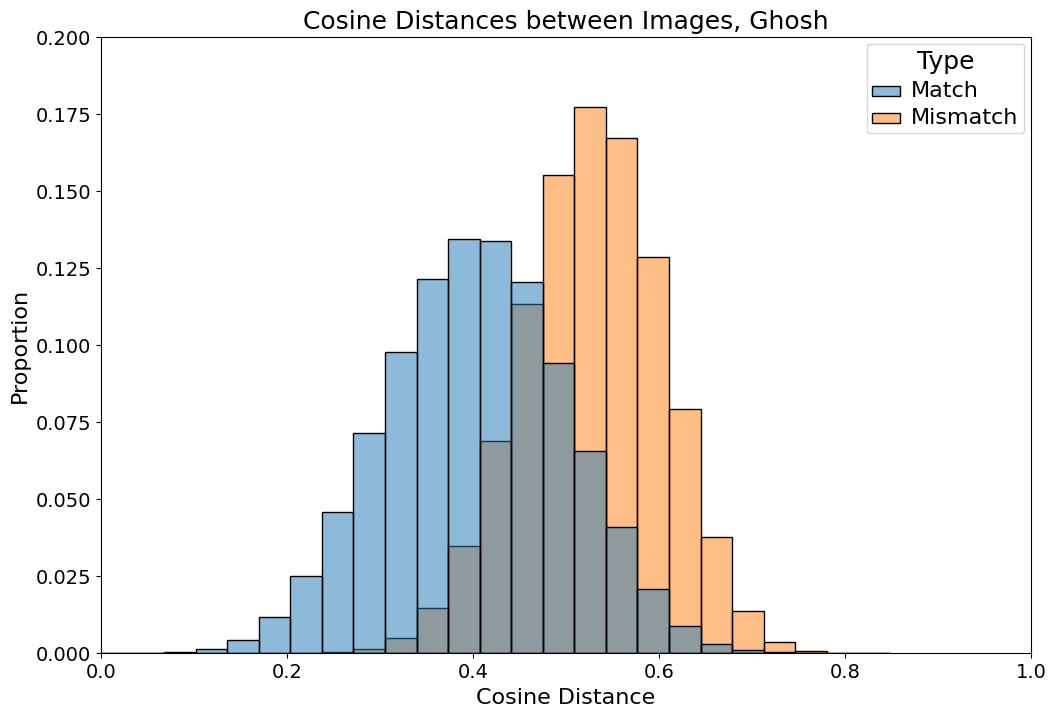

In [11]:
# Overlaid distributes of inter- and intra-label cos distances
fig, ax = plt.subplots(1, figsize = (12, 8))

sns.histplot(data = cos_df, x = 'cosine_distances', hue = 'Type',
             stat = 'proportion', common_norm = False, bins = 25, ax = ax);

ax.set_title('Cosine Distances between Images, Ghosh', fontsize = 18);
ax.set_xlabel('Cosine Distance', fontsize = 16);
ax.set_ylabel('Proportion', fontsize = 16);

ax.set_xlim([0, 1]);
ax.set_ylim([0, 0.2]);

plt.setp(ax.get_legend().get_texts(), fontsize = 16);
plt.setp(ax.get_legend().get_title(), fontsize = 18);

ax.tick_params(axis = 'both', labelsize = 14);
plt.savefig('./Visualizations/ghosh_cos_distances.png', format = 'png', bbox_inches = 'tight')

In [12]:
intra_cos_path = './data/vectorized/random_sample_intra_distances_cos.csv'
intra_cos_df = pd.read_csv(intra_cos_path)
inter_cos_df = dm.get_unbatched_frame('random_sample_inter_distances_', 'cos')
intra_cos_df['Type'] = 'Match'
inter_cos_df['Type'] = 'Mismatch'
cos_df = pd.concat([intra_cos_df, inter_cos_df])
intra_cos_df = 0
inter_cos_df = 0

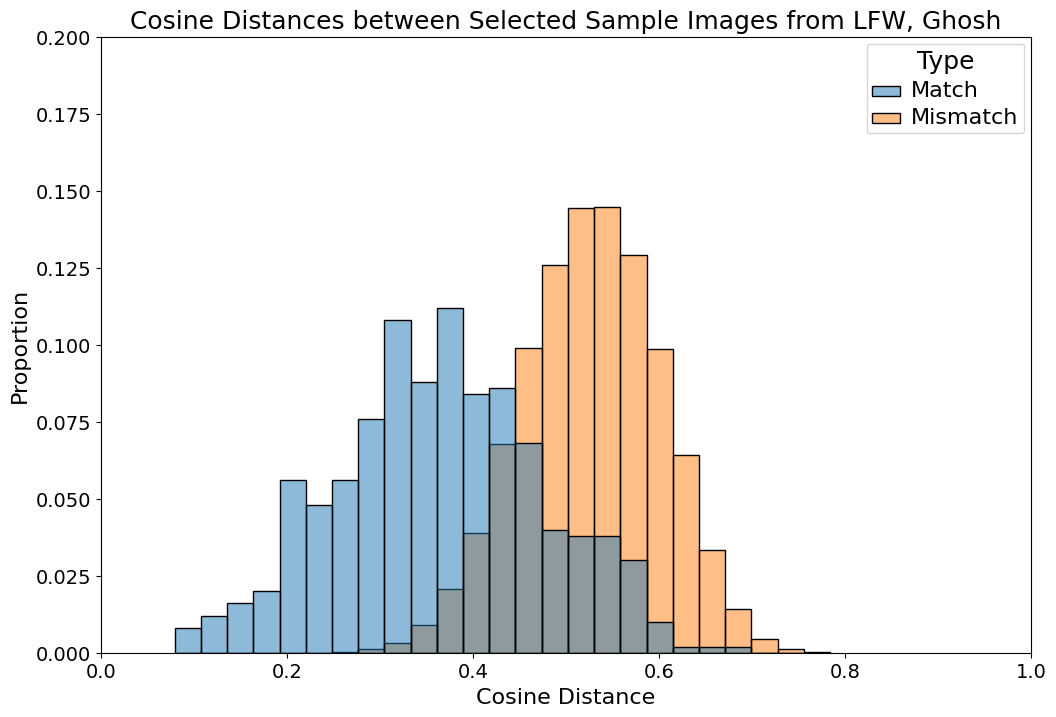

In [77]:
# Overlaid distributes of inter- and intra-label cos distances
fig, ax = plt.subplots(1, figsize = (12, 8))

sns.histplot(data = cos_df, x = 'cosine_distances', hue = 'Type',
             stat = 'proportion', common_norm = False, bins = 25, ax = ax);

ax.set_title('Cosine Distances between Selected Sample Images from LFW, Ghosh', fontsize = 18);
ax.set_xlabel('Cosine Distance', fontsize = 16);
ax.set_ylabel('Proportion', fontsize = 16);

ax.set_xlim([0, 1]);
ax.set_ylim([0, 0.2]);

plt.setp(ax.get_legend().get_texts(), fontsize = 16);
plt.setp(ax.get_legend().get_title(), fontsize = 18);

ax.tick_params(axis = 'both', labelsize = 14);
plt.savefig('./Visualizations/sample_cos_distances.png', format = 'png', bbox_inches = 'tight')

In [89]:
intra_cos_path = './data/personal_images_batch2/personal_intra_distances_cos.csv'
intra_cos_df = pd.read_csv(intra_cos_path)
inter_cos_df = dm.get_unbatched_frame('personal_inter_distances_', 'cos', root = './data/personal_images_batch2')
intra_cos_df['Type'] = 'Match'
inter_cos_df['Type'] = 'Mismatch'
cos_df = pd.concat([intra_cos_df, inter_cos_df])
intra_cos_df = 0
inter_cos_df = 0

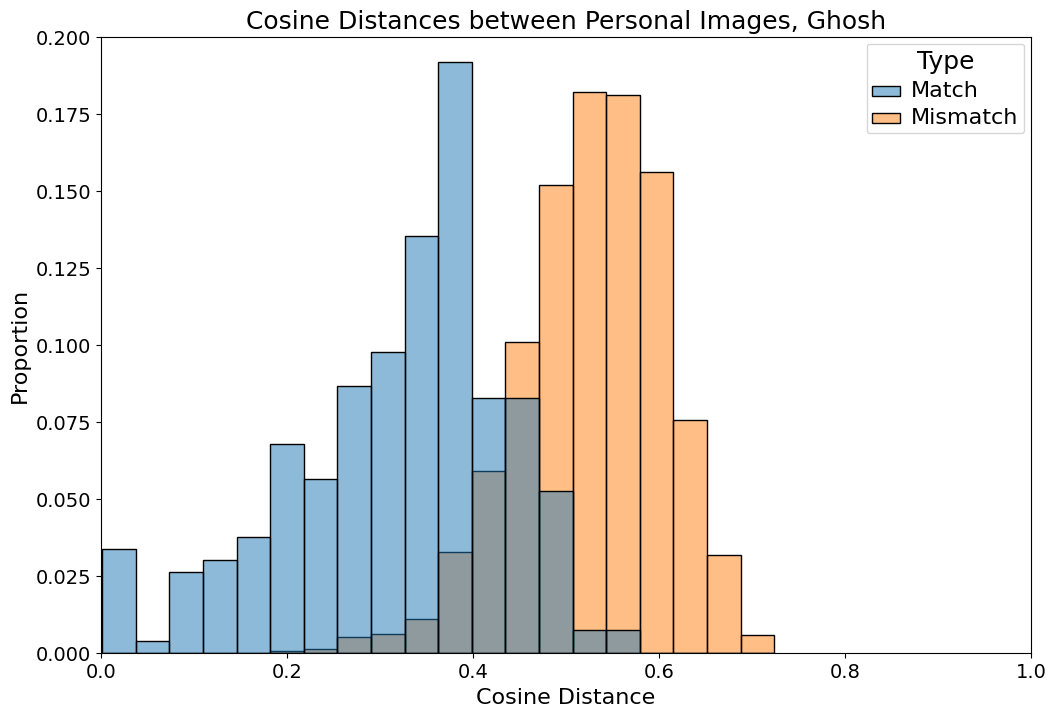

In [93]:
# Overlaid distributes of inter- and intra-label cos distances
fig, ax = plt.subplots(1, figsize = (12, 8))

sns.histplot(data = cos_df, x = 'cosine_distances', hue = 'Type',
             stat = 'proportion', common_norm = False, bins = 20, ax = ax);

ax.set_title('Cosine Distances between Personal Images, Ghosh', fontsize = 18);
ax.set_xlabel('Cosine Distance', fontsize = 16);
ax.set_ylabel('Proportion', fontsize = 16);

ax.set_xlim([0, 1]);
ax.set_ylim([0, 0.2]);

plt.setp(ax.get_legend().get_texts(), fontsize = 16);
plt.setp(ax.get_legend().get_title(), fontsize = 18);

ax.tick_params(axis = 'both', labelsize = 14);
plt.savefig('./Visualizations/personal_cos_distances.png', format = 'png', bbox_inches = 'tight')

# Image Distance Comparisons

In [2]:
model = api.init_model()

In [6]:
vector_dict = api.load_vector_dict('./data/dummy_dataset/reference_vectors')

In [ ]:
input_image_path = './data/dummy_dataset/input_images/Wayne_Gretzky_0002.jpg'

In [ ]:
match_details, threshold, metric = api.find_image_match(input_image_path, vector_dict, model,
                                                        threshold_strategy = 'balanced_acc',
                                                        threshold_strictness = 5, match_num = 5)

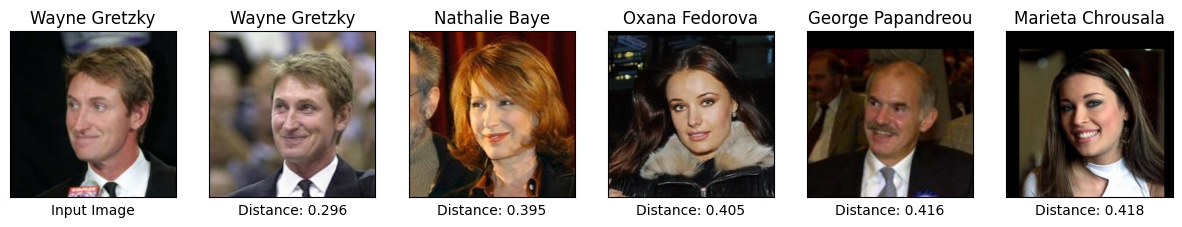

In [55]:
fig, ax  = plt.subplots(1, 6, figsize = (15, 3))

input_image = cv2.imread(input_image_path)[:, :, ::-1]
matched_images = [cv2.imread(os.path.join('./data/dummy_dataset/reference_images', f'{x[0]}.jpg'))[:, :, ::-1]
                  for x in match_details]

ax[0].imshow(input_image);
ax[0].set_title(f"{' '.join(input_image_path.split(os.path.sep)[-1].split('_')[0:-1])}")
ax[0].set_xlabel('Input Image')

for i in range(5):
    ax[i + 1].imshow(matched_images[i]);
    ax[i + 1].set_title(f"{' '.join(match_details[i][0].split('_')[0:-1])}")
    ax[i + 1].set_xlabel(f"Distance: {match_details[i][1]:.03f}")
    
for axis in ax:
    axis.set_xticks([]);
    axis.set_yticks([]);
    axis.grid(False);
    
plt.savefig('./Visualizations/good_matches.png', format = 'png', bbox_inches = 'tight')

In [59]:
input_image_path = './data/dummy_dataset/input_images/Sarah_Michelle_Gellar_0002.jpg'

In [60]:
match_details, threshold, metric = api.find_image_match(input_image_path, vector_dict, model,
                                                        threshold_strategy = 'balanced_acc',
                                                        threshold_strictness = 5, match_num = 5)

1/1 [==============================] - 0s 90ms/step


In [62]:
reference_image_path = './data/dummy_dataset/reference_images/Sarah_Michelle_Gellar_0001.jpg'
distance = utils.cosine_distance(api.get_image_vector(input_image_path, model = model),
                                 api.get_image_vector(reference_image_path, model = model))

1/1 [==============================] - 0s 81ms/step


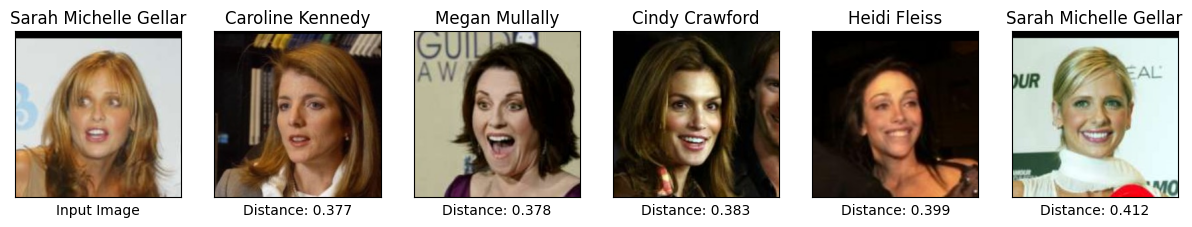

In [63]:
fig, ax  = plt.subplots(1, 6, figsize = (15, 3))

input_image = cv2.imread(input_image_path)[:, :, ::-1]
reference_image = cv2.imread(reference_image_path)[:, :, ::-1]
matched_images = [cv2.imread(os.path.join('./data/dummy_dataset/reference_images', f'{x[0]}.jpg'))[:, :, ::-1]
                  for x in match_details]

ax[0].imshow(input_image);
ax[0].set_title(f"{' '.join(input_image_path.split(os.path.sep)[-1].split('_')[0:-1])}")
ax[0].set_xlabel('Input Image')

for i in range(4):
    ax[i + 1].imshow(matched_images[i]);
    ax[i + 1].set_title(f"{' '.join(match_details[i][0].split('_')[0:-1])}")
    ax[i + 1].set_xlabel(f"Distance: {match_details[i][1]:.03f}")
    
ax[5].imshow(reference_image);
ax[5].set_title(f"{' '.join(reference_image_path.split(os.path.sep)[-1].split('_')[0:-1])}")
ax[5].set_xlabel(f"Distance: {distance:.03f}")
    
for axis in ax:
    axis.set_xticks([]);
    axis.set_yticks([]);
    axis.grid(False);
    
plt.savefig('./Visualizations/bad_matches.png', format = 'png', bbox_inches = 'tight')

In [3]:
vector_dict = api.load_vector_dict('./data/personal_images_batch2/reference_vectors', num_digits = 2)

In [74]:
input_image_path = './data/personal_images_batch2/input_images/Dan1-02.jpg'

In [75]:
match_details, threshold, metric = api.find_image_match(input_image_path, vector_dict, model,
                                                        threshold_strategy = 'balanced_acc',
                                                        threshold_strictness = 5, match_num = 5)

1/1 [==============================] - 0s 58ms/step


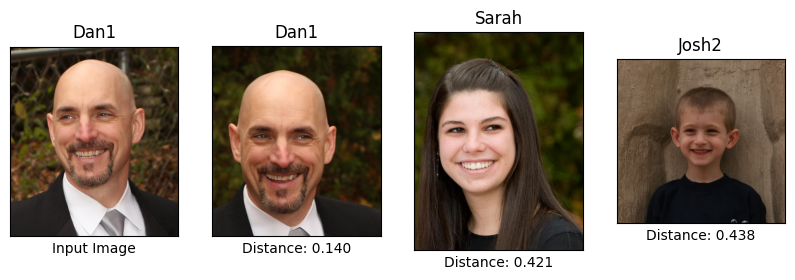

In [77]:
fig, ax  = plt.subplots(1, 4, figsize = (10, 4))

input_image = cv2.imread(input_image_path)[:, :, ::-1]
matched_images = [cv2.imread(os.path.join('./data/personal_images_batch2/reference_images', f'{x[0]}.jpg'))[:, :, ::-1]
                  for x in match_details]

ax[0].imshow(input_image);
ax[0].set_title(f"{' '.join(input_image_path.split(os.path.sep)[-1].split('-')[0:-1])}")
ax[0].set_xlabel('Input Image')

for i in range(3):
    ax[i + 1].imshow(matched_images[i]);
    ax[i + 1].set_title(f"{' '.join(match_details[i][0].split('-')[0:-1])}")
    ax[i + 1].set_xlabel(f"Distance: {match_details[i][1]:.03f}")
    
for axis in ax:
    axis.set_xticks([]);
    axis.set_yticks([]);
    axis.grid(False);
    
plt.savefig('./Visualizations/personal_good_matches.png', format = 'png', bbox_inches = 'tight')

In [153]:
input_image_path = './data/personal_images_batch2/input_images/Dan1-03.jpg'

In [154]:
match_details, threshold, metric = api.find_image_match(input_image_path, vector_dict, model,
                                                        threshold_strategy = 'balanced_acc',
                                                        threshold_strictness = 5, match_num = 5)

1/1 [==============================] - 0s 60ms/step


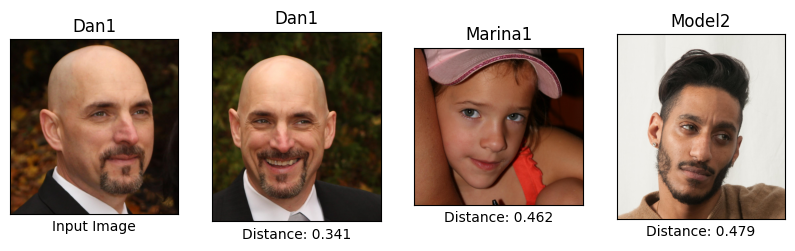

In [155]:
fig, ax  = plt.subplots(1, 4, figsize = (10, 4))

input_image = cv2.imread(input_image_path)[:, :, ::-1]
matched_images = [cv2.imread(os.path.join('./data/personal_images_batch2/reference_images', f'{x[0]}.jpg'))[:, :, ::-1]
                  for x in match_details]

ax[0].imshow(input_image);
ax[0].set_title(f"{' '.join(input_image_path.split(os.path.sep)[-1].split('-')[0:-1])}")
ax[0].set_xlabel('Input Image')

for i in range(3):
    ax[i + 1].imshow(matched_images[i]);
    ax[i + 1].set_title(f"{' '.join(match_details[i][0].split('-')[0:-1])}")
    ax[i + 1].set_xlabel(f"Distance: {match_details[i][1]:.03f}")
    
for axis in ax:
    axis.set_xticks([]);
    axis.set_yticks([]);
    axis.grid(False);
    
plt.savefig('./Visualizations/personal_medium_matches.png', format = 'png', bbox_inches = 'tight')

In [158]:
input_image_path = './data/personal_images_batch2/input_images/Dan2-02.jpg'

In [159]:
match_details, threshold, metric = api.find_image_match(input_image_path, vector_dict, model,
                                                        threshold_strategy = 'balanced_acc',
                                                        threshold_strictness = 5, match_num = 5)

1/1 [==============================] - 0s 64ms/step


In [161]:
reference_image_path = './data/personal_images_batch2/reference_images/Dan1-01.jpg'
distance = utils.cosine_distance(api.get_image_vector(input_image_path, model = model),
                                 api.get_image_vector(reference_image_path, model = model))

1/1 [==============================] - 0s 58ms/step


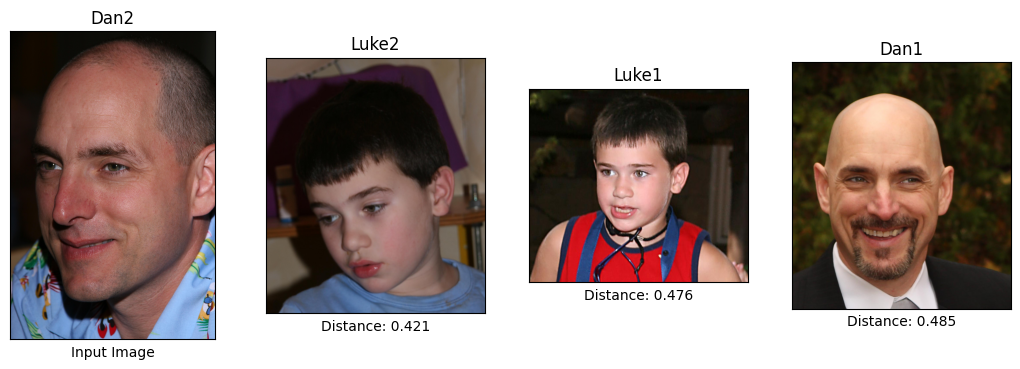

In [163]:
fig, ax  = plt.subplots(1, 4, figsize = (13, 4))

input_image = cv2.imread(input_image_path)[:, :, ::-1]
reference_image = cv2.imread(reference_image_path)[:, :, ::-1]
matched_images = [cv2.imread(os.path.join('./data/personal_images_batch2/reference_images', f'{x[0]}.jpg'))[:, :, ::-1]
                  for x in match_details]

ax[0].imshow(input_image);
ax[0].set_title(f"{' '.join(input_image_path.split(os.path.sep)[-1].split('-')[0:-1])}")
ax[0].set_xlabel('Input Image')

for i in range(2):
    ax[i + 1].imshow(matched_images[i + 1]);
    ax[i + 1].set_title(f"{' '.join(match_details[i + 1][0].split('-')[0:-1])}")
    ax[i + 1].set_xlabel(f"Distance: {match_details[i + 1][1]:.03f}")
    
ax[3].imshow(reference_image);
ax[3].set_title(f"{' '.join(reference_image_path.split(os.path.sep)[-1].split('-')[0:-1])}")
ax[3].set_xlabel(f"Distance: {distance:.03f}")
    
for axis in ax:
    axis.set_xticks([]);
    axis.set_yticks([]);
    axis.grid(False);
    
plt.savefig('./Visualizations/personal_poor_matches.png', format = 'png', bbox_inches = 'tight')

# Threshold Visualizations on LFW Sample

In [177]:
intra_path = './data/vectorized/random_sample_intra_distances_cos.csv'
intra_df = pd.read_csv(intra_path)
inter_df = dm.get_unbatched_frame('random_sample_inter_distances_', 'cos')
intra_df['type'] = 'Match'
inter_df['type'] = 'Mismatch'
cos_df = pd.concat([intra_df, inter_df])
intra_df = 0
inter_df = 0

In [178]:
iterative_thresholds = np.linspace(0.1, 0.9, 100).tolist()
for thresh in iterative_thresholds:
    cos_df[f'iterative_{thresh:.04f}'] = cos_df.cosine_distances.apply(lambda x: int(x < thresh))
    # Because each threshold columns has 1 for true and 0 for false, mean = positive count / total count
groupby = cos_df.drop('cosine_distances', axis = 1).groupby(['type']).mean()

In [179]:
threshold_columns = groupby.columns.values
class0_num, class1_num = cos_df['type'].value_counts().values
tprs, tnrs, fprs, fnrs = zip(*[st.expand_classification_rates(groupby.iloc[0][i], groupby.iloc[1][i])
                          for i in range(len(threshold_columns))])
tps, tns, fps, fns = zip(*[st.classification_rates_to_nominal(tprs[i], tnrs[i], fprs[i], fnrs[i], class1_num, class0_num)
                          for i in range(len(threshold_columns))])

In [180]:
prevalences = [st.prevalence(tps[i], fns[i], class1_num + class0_num) for i in range(len(threshold_columns))]
biases = [st.bias(tps[i], fps[i], class1_num + class0_num) for i in range(len(threshold_columns))]
balanced_accuracies = [st.balanced_accuracy_binary(tprs[i], tnrs[i]) for i in range(len(threshold_columns))]
precisions = [st.class_precision(tprs[i], fprs[i], class1_num, class0_num) for i in range(len(threshold_columns))]
informednesses = [st.informedness(tprs[i], tnrs[i]) for i in range(len(threshold_columns))]
markednesses = [st.markedness(tprs[i], fprs[i], class1_num, class0_num) for i in range(len(threshold_columns))]
mccs = [st.matthews_cc(tps[i], tns[i], fps[i], fns[i]) for i in range(len(threshold_columns))]

In [181]:
metrics_table = pd.DataFrame(columns = ['threshold_type', 'threshold_value',
                                        'balanced_accuracy', 'precision', 'recall',
                                        'f1_score', 'informedness', 'markedness', 'matthews_cc',
                                        'prevalence', 'bias'])

In [182]:
metrics_table.threshold_type = threshold_columns
metrics_table.threshold_value = iterative_thresholds
metrics_table.balanced_accuracy = balanced_accuracies
metrics_table.precision = precisions
metrics_table.recall = tprs
metrics_table.f1_score = 2 * (metrics_table.precision * metrics_table.recall) / (metrics_table.precision + metrics_table.recall)
metrics_table.informedness = informednesses
metrics_table.markedness = markednesses
metrics_table.matthews_cc = mccs
metrics_table.prevalence = prevalences
metrics_table.bias = biases

In [183]:
metrics_table

threshold_type  threshold_value  balanced_accuracy  precision  recall  \
0   iterative_0.1000         0.100000              0.503   1.000000   0.006   
1   iterative_0.1081         0.108081              0.504   1.000000   0.008   
2   iterative_0.1162         0.116162              0.505   1.000000   0.010   
3   iterative_0.1242         0.124242              0.507   1.000000   0.014   
4   iterative_0.1323         0.132323              0.510   1.000000   0.020   
..               ...              ...                ...        ...     ...   
95  iterative_0.8677         0.867677              0.500   0.003945   1.000   
96  iterative_0.8758         0.875758              0.500   0.003945   1.000   
97  iterative_0.8838         0.883838              0.500   0.003945   1.000   
98  iterative_0.8919         0.891919              0.500   0.003945   1.000   
99  iterative_0.9000         0.900000              0.500   0.003945   1.000   

    f1_score  informedness  markedness  matthews_cc  prevalence      bias  
0   0.011928         0.006    0.996079     0.077308    0.003945  0.000024  
1   0.015873         0.008    0.996087     0.089268    0.003945  0.000032  
2   0.019802         0.010    0.996095     0.099805    0.003945  0.000039  
3   0.027613         0.014    0.996110     0.118091    0.003945  0.000055  
4   0.039216         0.020    0.996134     0.141148    0.003945  0.000079  
..       ...           ...         ...          ...         ...       ...  
95  0.007858         0.000         NaN          NaN    0.003945  1.000000  
96  0.007858         0.000         NaN          NaN    0.003945  1.000000  
97  0.007858         0.000         NaN          NaN    0.003945  1.000000  
98  0.007858         0.000         NaN          NaN    0.003945  1.000000  
99  0.007858         0.000         NaN          NaN    0.003945  1.000000  

[100 rows x 11 columns]

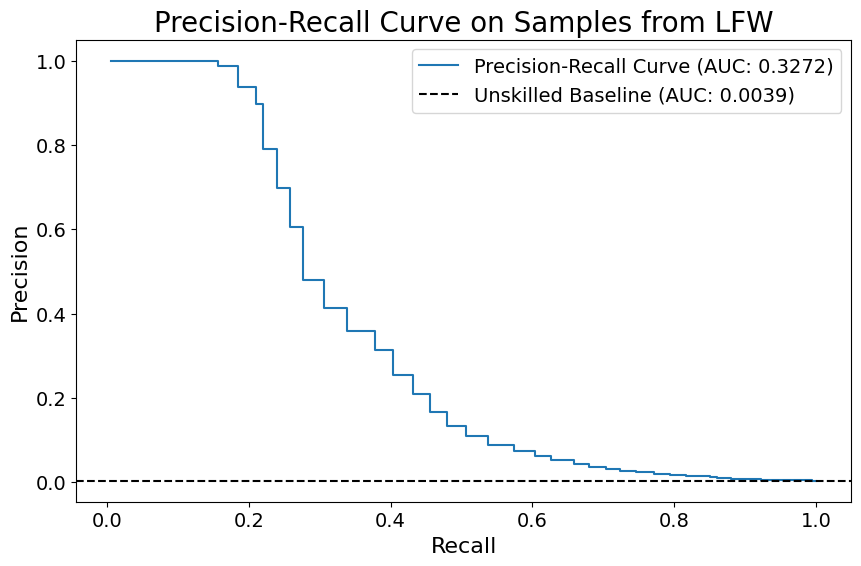

In [184]:
fig, ax = plt.subplots(figsize = (10, 6))

auc_score = auc(metrics_table.recall, metrics_table.precision)
class1_ratio = class1_num / (class1_num + class0_num)
prc = PrecisionRecallDisplay(metrics_table.precision, metrics_table.recall);
prc.plot(ax = ax)
hline = plt.axhline(y = class1_ratio, linestyle = '--', color = 'k');

ax.set_title('Precision-Recall Curve on Samples from LFW', fontsize = 20);
ax.set_xlabel('Recall', fontsize = 16)
ax.set_ylabel('Precision', fontsize = 16)
ax.tick_params(axis = 'both', labelsize = 14)
plt.legend([prc.line_, hline], [f'Precision-Recall Curve (AUC: {auc_score:.04f})',
                                f'Unskilled Baseline (AUC: {class1_ratio:.04f})'], fontsize = 14);

plt.savefig('./Visualizations/precision_recall_curve_lfw.png', format = 'png', bbox_inches = 'tight')

In [185]:
thresholds = [str(np.round(x, 4)) for x in [0.253535, 0.269697, 0.293939, 0.447475]]

In [186]:
thresholds_df = metrics_table.loc[metrics_table.threshold_type.str.contains('|'.join(thresholds))]\
                .drop(['threshold_type'], axis = 1)
thresholds_df.columns = ['Threshold', 'Balanced Accuracy', 'Precision', 'Recall', 'F1 Score',
                         'Informedness', 'Markedness', "Matthew's CC", 'Prevalence', 'Bias']

In [187]:
thresholds_df

Threshold  Balanced Accuracy  Precision  Recall  F1 Score  Informedness  \
19   0.253535           0.584996   0.988372   0.170  0.290102      0.169992   
21   0.269697           0.604952   0.897436   0.210  0.340357      0.209905   
24   0.293939           0.628667   0.605634   0.258  0.361851      0.257335   
43   0.447475           0.812796   0.020455   0.772  0.039853      0.625591   

    Markedness  Matthew's CC  Prevalence      Bias  
19    0.985096      0.409217    0.003945  0.000678  
21    0.894317      0.433268    0.003945  0.000923  
24    0.602702      0.393822    0.003945  0.001680  
43    0.019398      0.110160    0.003945  0.148877

In [188]:
thresholds_reduced = thresholds_df.drop(['Informedness', 'Markedness', 'Prevalence', 'Bias'], axis = 1)

In [189]:
tr_styled = thresholds_reduced.style.format(precision = 4)\
    .set_caption('Prediction Statistics at Various Thresholds on LFW Sample')\
    .set_properties(**{'width':'8em'})\
    .set_table_styles([
    {'selector': 'caption', 'props': 'caption-side: bottom; font-size: 1.25em; color: white; text-align: center'},
    {'selector': 'td', 'props': 'text-align: center;'},
    {'selector': 'th.index_name',
     'props': 'text-align: center; background-color: black;'
                         + 'border-right: 1px solid white; border-bottom: 1px solid white;'},
    {'selector': 'th.col_heading',
     'props': 'text-align: center; background-color: black;'
                         + 'border-bottom: 1px solid white;'}    
    ], overwrite = False)\
    .apply(lambda x: ['font-weight: bold; border-right: 1px solid white' if x.name == 'Threshold' else '' for i in x])\
    .highlight_max(axis = 0, props = 'color: white; background-color: black; border: 1px solid white',
                   subset = ['Balanced Accuracy', 'Precision', 'Recall', 'F1 Score', "Matthew's CC"])\
    .hide_index()
tr_styled

In [190]:
thresh_styled = thresholds_df.style.use(tr_styled.export())\
    .highlight_max(axis = 0, props = 'color: white; background-color: black; border: 1px solid white',
                   subset = ['Balanced Accuracy', 'Precision', 'Recall', 'F1 Score',
                             'Informedness', 'Markedness', "Matthew's CC"])\
    .set_caption('Prediction Statistics at Various Thresholds on LFW Sample')

In [191]:
thresh_styled

In [192]:
cos_df.rename(columns={'type': 'Type'}, inplace = True)

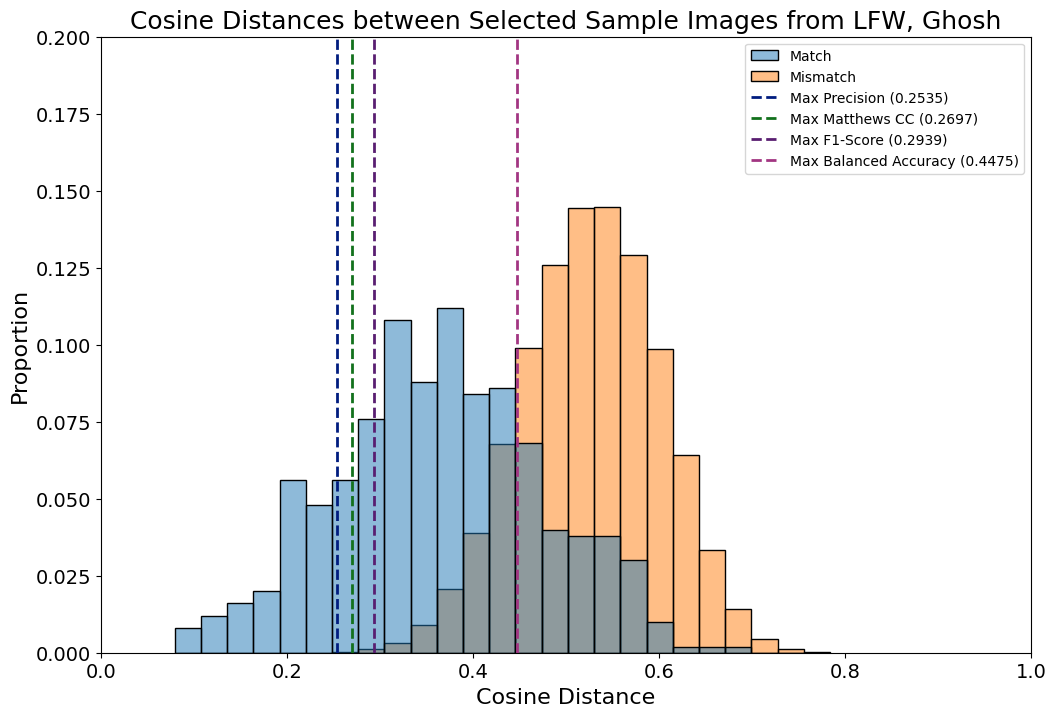

In [193]:
# Overlaid distributes of inter- and intra-label cos distances
fig, ax = plt.subplots(1, figsize = (12, 8))

sns.histplot(data = cos_df, x = 'cosine_distances', hue = 'Type',
             stat = 'proportion', common_norm = False, bins = 25, ax = ax);

ax.set_title('Cosine Distances between Selected Sample Images from LFW, Ghosh', fontsize = 18);
ax.set_xlabel('Cosine Distance', fontsize = 16);
ax.set_ylabel('Proportion', fontsize = 16);

ax.set_xlim([0, 1]);
ax.set_ylim([0, 0.2]);

plt.setp(ax.get_legend().get_texts(), fontsize = 16);
plt.setp(ax.get_legend().get_title(), fontsize = 18);

ax.tick_params(axis = 'both', labelsize = 14);
precision = ax.axvline(x = thresholds_df.iloc[0].Threshold, linestyle = '--',
                       color = sns.color_palette('dark')[0], linewidth = 2);
mcc = ax.axvline(x = thresholds_df.iloc[1].Threshold, linestyle = '--',
                 color = sns.color_palette('dark')[2], linewidth = 2);
f1 = ax.axvline(x = thresholds_df.iloc[2].Threshold, linestyle = '--',
                color = sns.color_palette('dark')[4], linewidth = 2);
acc = ax.axvline(x = thresholds_df.iloc[3].Threshold, linestyle = '--',
                 color = sns.color_palette('dark')[6], linewidth = 2);
children = plt.gca().get_children();
plt.legend([children[26], children[0], precision, mcc, f1, acc],
           ['Match', 'Mismatch',
            f'Max Precision ({thresholds_df.iloc[0].Threshold:.04f})',
            f'Max Matthews CC ({thresholds_df.iloc[1].Threshold:.04f})',
            f'Max F1-Score ({thresholds_df.iloc[2].Threshold:.04f})',
            f'Max Balanced Accuracy ({thresholds_df.iloc[3].Threshold:.04f})']);

plt.savefig('./Visualizations/distances_with_thresholds_lfw.png', format = 'png', bbox_inches = 'tight')

# Threshold Visualizations on Personal Images

In [194]:
intra_path = './data/personal_images_batch2/personal_intra_distances_cos.csv'
intra_df = pd.read_csv(intra_path)
inter_df = dm.get_unbatched_frame('personal_inter_distances_', 'cos', root = './data/personal_images_batch2')
intra_df['type'] = 'Match'
inter_df['type'] = 'Mismatch'
cos_df = pd.concat([intra_df, inter_df])
intra_df = 0
inter_df = 0

In [195]:
iterative_thresholds = np.linspace(0.1, 0.9, 100).tolist()
for thresh in iterative_thresholds:
    cos_df[f'iterative_{thresh:.04f}'] = cos_df.cosine_distances.apply(lambda x: int(x < thresh))
    # Because each threshold columns has 1 for true and 0 for false, mean = positive count / total count
groupby = cos_df.drop('cosine_distances', axis = 1).groupby(['type']).mean()

In [196]:
threshold_columns = groupby.columns.values
class0_num, class1_num = cos_df['type'].value_counts().values
tprs, tnrs, fprs, fnrs = zip(*[st.expand_classification_rates(groupby.iloc[0][i], groupby.iloc[1][i])
                          for i in range(len(threshold_columns))])
tps, tns, fps, fns = zip(*[st.classification_rates_to_nominal(tprs[i], tnrs[i], fprs[i], fnrs[i], class1_num, class0_num)
                          for i in range(len(threshold_columns))])

In [197]:
prevalences = [st.prevalence(tps[i], fns[i], class1_num + class0_num) for i in range(len(threshold_columns))]
biases = [st.bias(tps[i], fps[i], class1_num + class0_num) for i in range(len(threshold_columns))]
balanced_accuracies = [st.balanced_accuracy_binary(tprs[i], tnrs[i]) for i in range(len(threshold_columns))]
precisions = [st.class_precision(tprs[i], fprs[i], class1_num, class0_num) for i in range(len(threshold_columns))]
informednesses = [st.informedness(tprs[i], tnrs[i]) for i in range(len(threshold_columns))]
markednesses = [st.markedness(tprs[i], fprs[i], class1_num, class0_num) for i in range(len(threshold_columns))]
mccs = [st.matthews_cc(tps[i], tns[i], fps[i], fns[i]) for i in range(len(threshold_columns))]

In [198]:
metrics_table = pd.DataFrame(columns = ['threshold_type', 'threshold_value',
                                        'balanced_accuracy', 'precision', 'recall',
                                        'f1_score', 'informedness', 'markedness', 'matthews_cc',
                                        'prevalence', 'bias'])

In [199]:
metrics_table.threshold_type = threshold_columns
metrics_table.threshold_value = iterative_thresholds
metrics_table.balanced_accuracy = balanced_accuracies
metrics_table.precision = precisions
metrics_table.recall = tprs
metrics_table.f1_score = 2 * (metrics_table.precision * metrics_table.recall) / (metrics_table.precision + metrics_table.recall)
metrics_table.informedness = informednesses
metrics_table.markedness = markednesses
metrics_table.matthews_cc = mccs
metrics_table.prevalence = prevalences
metrics_table.bias = biases

In [215]:
metrics_table

threshold_type  threshold_value  balanced_accuracy  precision    recall  \
0   iterative_0.1000         0.100000           0.528195   1.000000  0.056391   
1   iterative_0.1081         0.108081           0.530075   1.000000  0.060150   
2   iterative_0.1162         0.116162           0.535714   1.000000  0.071429   
3   iterative_0.1242         0.124242           0.539474   1.000000  0.078947   
4   iterative_0.1323         0.132323           0.539474   1.000000  0.078947   
..               ...              ...                ...        ...       ...   
95  iterative_0.8677         0.867677           0.500000   0.059574  1.000000   
96  iterative_0.8758         0.875758           0.500000   0.059574  1.000000   
97  iterative_0.8838         0.883838           0.500000   0.059574  1.000000   
98  iterative_0.8919         0.891919           0.500000   0.059574  1.000000   
99  iterative_0.9000         0.900000           0.500000   0.059574  1.000000   

    f1_score  informedness  markedness  matthews_cc  prevalence      bias  
0   0.106762      0.056391    0.943596     0.230674    0.059574  0.003359  
1   0.113475      0.060150    0.943808     0.238265    0.059574  0.003583  
2   0.133333      0.071429    0.944444     0.259731    0.059574  0.004255  
3   0.146341      0.078947    0.944869     0.273121    0.059574  0.004703  
4   0.146341      0.078947    0.944869     0.273121    0.059574  0.004703  
..       ...           ...         ...          ...         ...       ...  
95  0.112450      0.000000         NaN          NaN    0.059574  1.000000  
96  0.112450      0.000000         NaN          NaN    0.059574  1.000000  
97  0.112450      0.000000         NaN          NaN    0.059574  1.000000  
98  0.112450      0.000000         NaN          NaN    0.059574  1.000000  
99  0.112450      0.000000         NaN          NaN    0.059574  1.000000  

[100 rows x 11 columns]

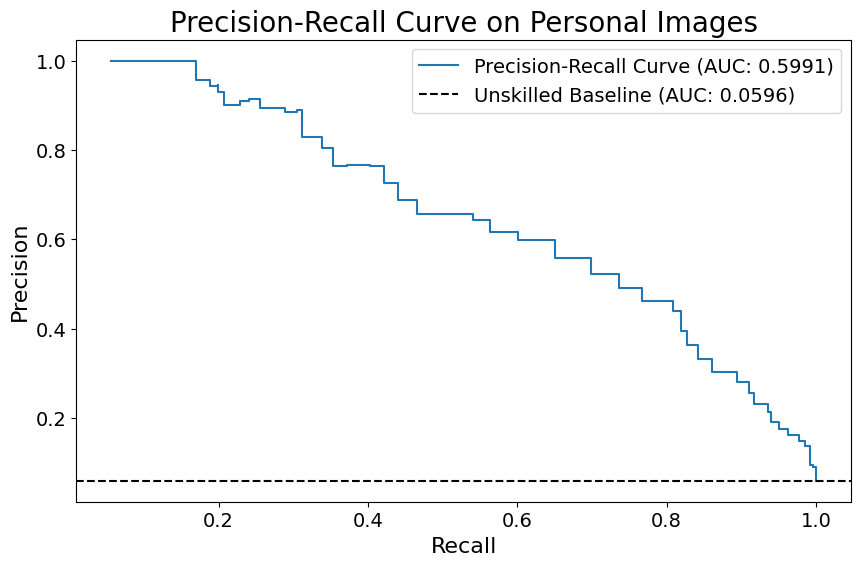

In [202]:
fig, ax = plt.subplots(figsize = (10, 6))

auc_score = auc(metrics_table.recall, metrics_table.precision)
class1_ratio = class1_num / (class1_num + class0_num)
prc = PrecisionRecallDisplay(metrics_table.precision, metrics_table.recall);
prc.plot(ax = ax)
hline = plt.axhline(y = class1_ratio, linestyle = '--', color = 'k');

ax.set_title('Precision-Recall Curve on Personal Images', fontsize = 20);
ax.set_xlabel('Recall', fontsize = 16)
ax.set_ylabel('Precision', fontsize = 16)
ax.tick_params(axis = 'both', labelsize = 14)
plt.legend([prc.line_, hline], [f'Precision-Recall Curve (AUC: {auc_score:.04f})',
                                f'Unskilled Baseline (AUC: {class1_ratio:.04f})'], fontsize = 14);

plt.savefig('./Visualizations/precision_recall_curve_personal.png', format = 'png', bbox_inches = 'tight')

In [222]:
thresholds = [str(np.round(x, 4)) for x in [0.213131, 0.374747, 0.382828, 0.447475]]

In [223]:
thresholds_df = metrics_table.loc[metrics_table.threshold_type.str.contains('|'.join(thresholds))]\
                .drop(['threshold_type'], axis = 1)
thresholds_df.columns = ['Threshold', 'Balanced Accuracy', 'Precision', 'Recall', 'F1 Score',
                         'Informedness', 'Markedness', "Matthew's CC", 'Prevalence', 'Bias']

In [224]:
thresholds_df

Threshold  Balanced Accuracy  Precision    Recall  F1 Score  Informedness  \
14   0.213131           0.599267   0.946429  0.199248  0.329193      0.198534   
34   0.374747           0.808875   0.558065  0.650376  0.600694      0.617749   
35   0.382828           0.829381   0.522472  0.699248  0.598071      0.658762   
43   0.447475           0.874970   0.281324  0.894737  0.428058      0.749940   

    Markedness  Matthew's CC  Prevalence      Bias  
14    0.898118      0.422264    0.059574  0.012542  
34    0.535682      0.575254    0.059574  0.069429  
35    0.503002      0.575638    0.059574  0.079731  
43    0.273587      0.452961    0.059574  0.189474

In [225]:
thresholds_reduced = thresholds_df.drop(['Informedness', 'Markedness', 'Prevalence', 'Bias'], axis = 1)

In [226]:
tr_styled = thresholds_reduced.style.format(precision = 4)\
    .set_caption('Prediction Statistics at Various Thresholds on Personal Images')\
    .set_properties(**{'width':'8em'})\
    .set_table_styles([
    {'selector': 'caption', 'props': 'caption-side: bottom; font-size: 1.25em; color: white; text-align: center'},
    {'selector': 'td', 'props': 'text-align: center;'},
    {'selector': 'th.index_name',
     'props': 'text-align: center; background-color: black;'
                         + 'border-right: 1px solid white; border-bottom: 1px solid white;'},
    {'selector': 'th.col_heading',
     'props': 'text-align: center; background-color: black;'
                         + 'border-bottom: 1px solid white;'}    
    ], overwrite = False)\
    .apply(lambda x: ['font-weight: bold; border-right: 1px solid white' if x.name == 'Threshold' else '' for i in x])\
    .highlight_max(axis = 0, props = 'color: white; background-color: black; border: 1px solid white',
                   subset = ['Balanced Accuracy', 'Precision', 'Recall', 'F1 Score', "Matthew's CC"])\
    .hide_index()
tr_styled

In [227]:
thresh_styled = thresholds_df.style.use(tr_styled.export())\
    .highlight_max(axis = 0, props = 'color: white; background-color: black; border: 1px solid white',
                   subset = ['Balanced Accuracy', 'Precision', 'Recall', 'F1 Score',
                             'Informedness', 'Markedness', "Matthew's CC"])\
    .set_caption('Prediction Statistics at Various Thresholds on Personal Images')

In [228]:
thresh_styled

In [229]:
cos_df.rename(columns={'type': 'Type'}, inplace = True)

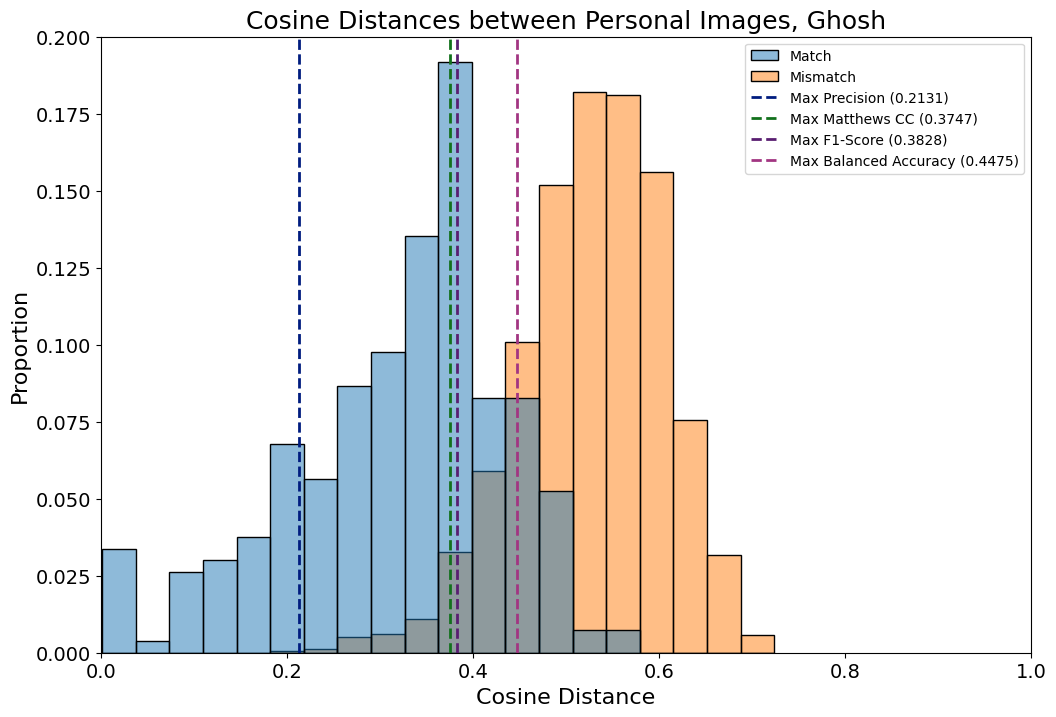

In [230]:
# Overlaid distributes of inter- and intra-label cos distances
fig, ax = plt.subplots(1, figsize = (12, 8))

sns.histplot(data = cos_df, x = 'cosine_distances', hue = 'Type',
             stat = 'proportion', common_norm = False, bins = 20, ax = ax);

ax.set_title('Cosine Distances between Personal Images, Ghosh', fontsize = 18);
ax.set_xlabel('Cosine Distance', fontsize = 16);
ax.set_ylabel('Proportion', fontsize = 16);

ax.set_xlim([0, 1]);
ax.set_ylim([0, 0.2]);

plt.setp(ax.get_legend().get_texts(), fontsize = 16);
plt.setp(ax.get_legend().get_title(), fontsize = 18);

ax.tick_params(axis = 'both', labelsize = 14);
precision = ax.axvline(x = thresholds_df.iloc[0].Threshold, linestyle = '--',
                       color = sns.color_palette('dark')[0], linewidth = 2);
mcc = ax.axvline(x = thresholds_df.iloc[1].Threshold, linestyle = '--',
                 color = sns.color_palette('dark')[2], linewidth = 2);
f1 = ax.axvline(x = thresholds_df.iloc[2].Threshold, linestyle = '--',
                color = sns.color_palette('dark')[4], linewidth = 2);
acc = ax.axvline(x = thresholds_df.iloc[3].Threshold, linestyle = '--',
                 color = sns.color_palette('dark')[6], linewidth = 2);
children = plt.gca().get_children();
plt.legend([children[21], children[0], precision, mcc, f1, acc],
           ['Match', 'Mismatch',
            f'Max Precision ({thresholds_df.iloc[0].Threshold:.04f})',
            f'Max Matthews CC ({thresholds_df.iloc[1].Threshold:.04f})',
            f'Max F1-Score ({thresholds_df.iloc[2].Threshold:.04f})',
            f'Max Balanced Accuracy ({thresholds_df.iloc[3].Threshold:.04f})']);

plt.savefig('./Visualizations/distances_with_thresholds_personal.png', format = 'png', bbox_inches = 'tight')